In [1]:
import sys

sys.path.append("../end2end-stealing")

In [2]:
import torch
from taskdataset import TaskDataset


dataset = torch.load("data/ModelStealingPub.pt")

In [3]:
len(dataset)

13000

In [4]:
import vision_transformer as vits
import torchvision.models as models
import torchvision
import numpy as np

In [6]:
!pip install git+https://github.com/nasa/pretrained-microscopy-models

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/nasa/pretrained-microscopy-models to /tmp/pip-req-build-s5645cmz
  Running command git clone --filter=blob:none --quiet https://github.com/nasa/pretrained-microscopy-models /tmp/pip-req-build-s5645cmz
  Resolved https://github.com/nasa/pretrained-microscopy-models to commit 4d98e609a3177dadcd9d5d1f12dac59260180dbf
  Preparing metadata (setup.py) ... done
  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 803.4 kB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 2.5 MB/s eta 0:00:0031m2.2 MB/s eta 0:00:

In [12]:
import torch
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo

model = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False)
# url = pmm.util.get_pretrained_microscopynet_url("resnet50", "image-micronet")
# model.load_state_dict(model_zoo.load_url(url))
# model.eval()  # <- MicrosNet model for classifcation or transfer learning

Using cache found in /home/bartosz.cywinski@aiclearing.com/.cache/torch/hub/pytorch_vision_v0.10.0


In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
victim_model = models.__dict__["resnet50"]()
# checkpoint = torch.load(
#     "/home/bartosz.cywinski@aiclearing.com/code/ensemble-ai2024/end2end-stealing/pretrained_weights/checkpoint_0099.pth.tar",
#     map_location="cpu",
# )
state_dict = model_zoo.load_url(url)
for k in list(state_dict.keys()):
    # retain only encoder up to before the embedding layer
    if k.startswith("module.encoder") and not k.startswith("module.encoder.fc"):
        # remove prefix
        state_dict[k[len("module.encoder.") :]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
# print("state dict", state_dict.keys())
victim_model.load_state_dict(state_dict, strict=False)
victim_model.avgpool = torch.nn.Sequential(
    torch.nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
    torch.nn.AdaptiveAvgPool2d(output_size=(1, 1)),
)
victim_model.fc = torch.nn.Identity()
victim_model.cuda()
victim_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
dataset[0]

(73838,
 <PIL.Image.Image image mode=RGB size=32x32 at 0x7149F6C85540>,
 '40019202')

In [73]:
all_images = [
    torchvision.transforms.ToTensor()(img.convert("RGB")) for iid, img, label in dataset
]

In [74]:
all_images = torch.stack(all_images)

In [75]:
torch.mean(all_images, dim=(0, 2, 3))

tensor([0.3175, 0.2710, 0.3050])

In [76]:
torch.std(all_images, dim=(0, 2, 3))

tensor([0.3098, 0.2590, 0.2925])

In [77]:
features = []
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.3175, 0.2710, 0.3050], std=[0.3098, 0.2590, 0.2925]
        ),
    ]
)

for iid, img, label in dataset:
    with torch.no_grad():
        img = img.convert("RGB")
        img = transform(img).unsqueeze(0)

        victim_model(img.to("cuda"))
        features.append(victim_model(img.to("cuda")).cpu().numpy())

In [78]:
features = torch.from_numpy(np.array(features))
features = features.view(features.shape[0], -1)

In [79]:
features.shape

torch.Size([13000, 512])

In [80]:
all_images.shape

torch.Size([13000, 3, 32, 32])

In [ ]:
torch.save(
    features,
    "../end2end-stealing/data/features.pt",
)
torch.save(
    all_images,
    "../end2end-stealing/data/images.pt",
)

In [81]:
import umap

In [82]:
reducer = umap.UMAP()

In [83]:
embs = reducer.fit_transform(features)

In [84]:
labels = [label for iid, img, label in dataset]

In [85]:
label_map = {l: i for i, l in enumerate(set(labels))}

In [86]:
labels_int = [label_map[l] for l in labels]

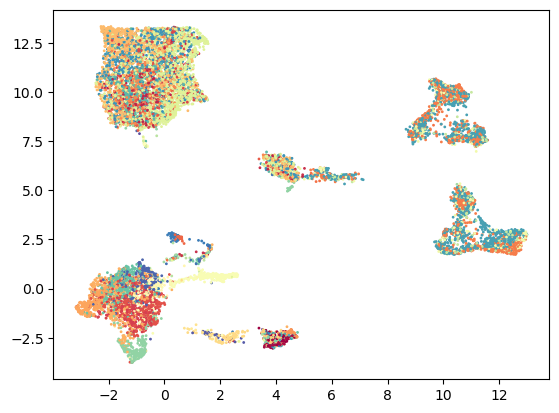

In [87]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    embs[:, 0], embs[:, 1], label=labels_int, c=labels_int, cmap="Spectral", s=1
)
plt.show()

In [88]:
features.shape

torch.Size([13000, 512])

In [89]:
import random
import tqdm


def get_wodzes(features, images, n_wodzes=10, near_dist=None):
    images_to_return = torch.zeros_like(images[: n_wodzes + 1])
    features_to_return = torch.zeros_like(features[: n_wodzes + 1])
    images_not_chosen = images
    features_not_chosen = features

    random_index = random.randint(0, len(features))

    features_to_return[0] = features_not_chosen[random_index]
    images_to_return[0] = images_not_chosen[random_index]
    # features_to_return.append(features_not_chosen[random_index])
    # images_to_return.append(images_not_chosen[random_index])
    # indexes.append(random_index)
    features_not_chosen = torch.cat(
        (features_not_chosen[:random_index], features_not_chosen[random_index + 1 :])
    )
    images_not_chosen = torch.cat(
        (images_not_chosen[:random_index], images_not_chosen[random_index + 1 :])
    )

    for i in tqdm.tqdm(range(n_wodzes)):
        distances = torch.cdist(features_to_return[:i], features_not_chosen)
        sum_distances = torch.sum(distances, dim=0, keepdim=True)
        sorted_indices = torch.argsort(sum_distances, descending=True)[0]
        # max_value_index = torch.argmax(sum_distances).item()
        # if near_dist is not None:
        #     max_val_distances = torch.cdist(features[max_value_index], features)
        #     mask = max_val_distances < near_dist
        #     indices = torch.nonzero(mask, as_tuple=False)
        #     near_indices.extend(indices)
        #     near_images.extend([dataset[i] for i in indices])
        # for idx in sorted_indices:
        #     if idx not in indexes:
        #         max_value_index = idx.item()
        #         break

        # indexes.append(max_value_index)
        images_to_return[i + 1] = images_not_chosen[sorted_indices[0]]
        features_to_return[i + 1] = features_not_chosen[sorted_indices[0]]
        # images_to_return.append(images_not_chosen[sorted_indices[0]])
        # features_to_return.append(features_not_chosen[sorted_indices[0]])
        features_not_chosen = torch.cat(
            (
                features_not_chosen[: sorted_indices[0]],
                features_not_chosen[sorted_indices[0] + 1 :],
            )
        )
        images_not_chosen = torch.cat(
            (
                images_not_chosen[: sorted_indices[0]],
                images_not_chosen[sorted_indices[0] + 1 :],
            )
        )

    # indexes.extend(near_indices)
    # images_to_return.extend(near_images)

    return features_to_return, images_to_return

In [90]:
import matplotlib.pyplot as plt

xd_feat, xd_images = get_wodzes(features, all_images, 8000)

  0%|          | 2/8000 [00:00<09:44, 13.69it/s]

100%|██████████| 8000/8000 [47:56<00:00,  2.78it/s]


In [101]:
xd_feat.shape

torch.Size([8001, 512])

In [102]:
xd_images.shape

torch.Size([8001, 3, 32, 32])

In [103]:
torch.save(
    xd_feat,
    "xd_features.pt",
)

In [104]:
torch.save(
    xd_images,
    "xd_images.pt",
)

In [ ]:
from torchvision.utils import make_grid

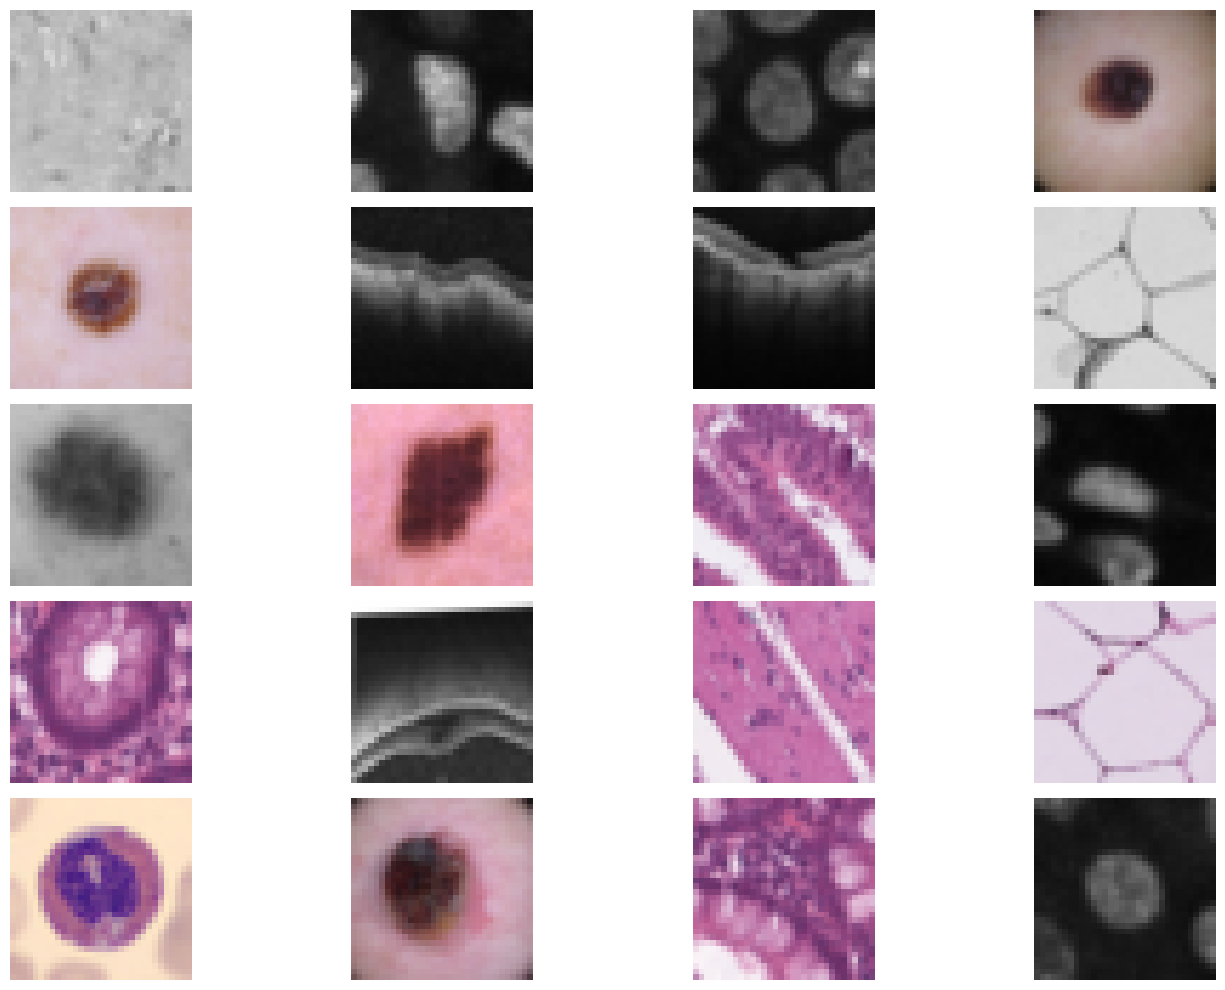

In [91]:
def plot_images(xd_images):
    fig, axs = plt.subplots(5, 4, figsize=(15, 10))

    for i, ax in enumerate(axs.flatten()):
        ax.imshow(xd_images[i].permute(1, 2, 0))
        ax.axis("off")

    plt.tight_layout()
    plt.show()


plot_images(xd_images)

In [93]:
xd_embs = reducer.transform(xd_feat)

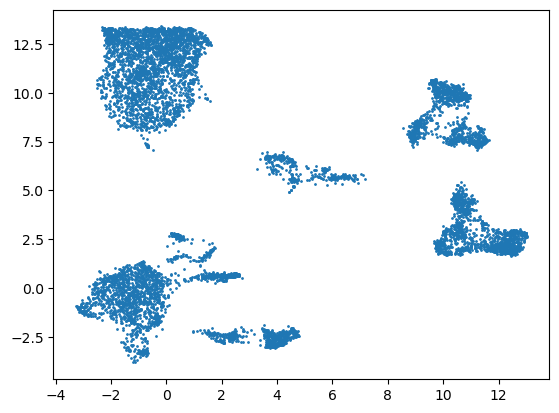

In [94]:
plt.figure()
plt.scatter(xd_embs[:, 0], xd_embs[:, 1], cmap="Spectral", s=1)
plt.show()

In [95]:
xd_images_torch = torch.save(xd_images, "data/xd_images.pt")

In [96]:
import numpy as np

# Convert xd_images to a NumPy array
xd_images_arr = np.array(xd_images)

# Save xd_images_arr as a NumPy array
np.savez("xd_images.npz", xd_images_arr)

In [97]:
baseline_feat = features[
    np.random.choice(np.arange(0, len(dataset)), 8000, replace=False)
]

In [98]:
baseline_embs = reducer.transform(baseline_feat)

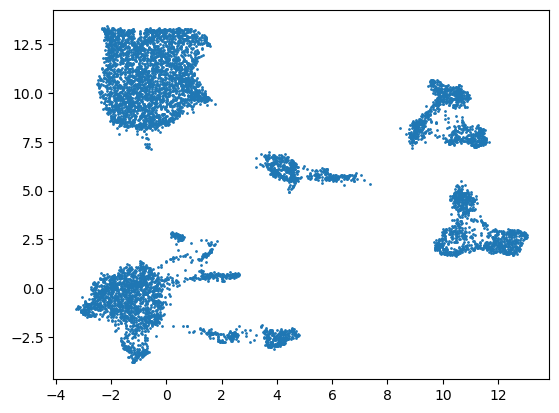

In [99]:
plt.figure()
plt.scatter(baseline_embs[:, 0], baseline_embs[:, 1], cmap="Spectral", s=1)
plt.show()

In [105]:
baseline_images = all_images[
    np.random.choice(np.arange(0, len(dataset)), 8000, replace=False)
]

In [107]:
baseline_images.shape

torch.Size([8000, 3, 32, 32])

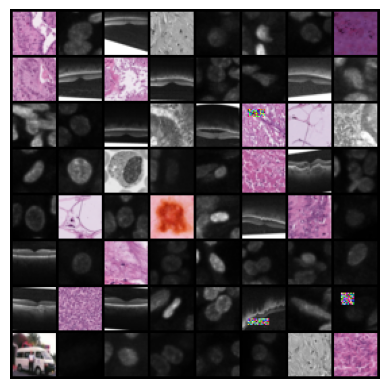

In [117]:
from torchvision.utils import make_grid

plt.imshow(
    make_grid(
        baseline_images[:64],
        nrow=8,
        padding=2,
        normalize=True,
        range=None,
        scale_each=False,
        pad_value=0,
    ).permute(1, 2, 0)
)
plt.axis("off")
plt.show()

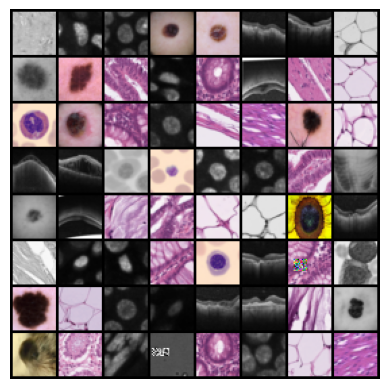

In [118]:
plt.imshow(
    make_grid(
        xd_images[:64],
        nrow=8,
        padding=2,
        normalize=True,
        range=None,
        scale_each=False,
        pad_value=0,
    ).permute(1, 2, 0)
)
plt.axis("off")
plt.show()

In [ ]:
len(xd_images)

1001

In [ ]:
distances = torch.cdist(features, features)

In [ ]:
distances.shape

torch.Size([13000, 13000])

In [ ]:
order = list(distances.mean(dim=1).sort()[1])[::-1]

In [ ]:
order = [x.item() for x in order]

In [ ]:
all_images = [img for iid, img, label in dataset]
chosen_images = np.array(all_images)[order][:100]

/tmp/ipykernel_71570/3161812555.py:2: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  chosen_images = np.array(all_images)[order][:100]
/tmp/ipykernel_71570/3161812555.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chosen_images = np.array(all_images)[order][:100]


In [ ]:
len(chosen_images)

100

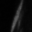

In [ ]:
chosen_images[0]

In [ ]:
chosen_features = features[order][:100]

In [ ]:
sorted_embs = embs[order]